In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('..')

from gym_minigrid_navigation.utils import show_video
from navigation_policy import gen_env, get_agent, run_episode, run_episodes

from rewards import get_reward_function
from utils import init_logger, switch_reproducibility_on, display_stats

from expected_steps import ExpectedStepsAmountLeaner
from rewards import ExpectedStepsAmountReward

import logging
logger = logging.getLogger(__name__)

init_logger('__main__')

init_logger('dqn')
init_logger('expected_steps')
init_logger('navigation_policy')
init_logger('gym_minigrid_navigation.environments')

### config 

In [4]:
from pyhocon import ConfigFactory

config = ConfigFactory.parse_file('../conf/minigrid_dqn_navigation_draft.hocon')
config['env']['video_path'] = '../outputs/video/'

switch_reproducibility_on(config['seed'])

### agent and steps amount model

In [5]:
agent = get_agent(config)

2021-02-15 19:23:55,695 INFO    dqn                    : Running on device: cuda:0


### steps amount model trainings 

In [8]:
config['expected_steps_params']['buffer_size'] = 1000
expected_steps_learner = ExpectedStepsAmountLeaner(config['expected_steps_params'])

In [9]:
env = gen_env(config['env'], reward_function=lambda *args: 0)
# expected_steps_learner.model.fc[-1].bias.data.fill_(20.)

for i in range(50):

    # expected_steps_learner.reset_buffer()
    expected_steps_learner.collect_episodes(env, agent)
    expected_steps_learner.learn(verbose=True)

2021-02-15 19:39:58,296 INFO    expected_steps         : Collecting episodes:  0
2021-02-15 19:40:43,031 INFO    expected_steps         : Expected steps L1Loss:  9.021610647958259
2021-02-15 19:40:43,033 INFO    expected_steps         : Collecting episodes:  0
2021-02-15 19:41:39,860 INFO    expected_steps         : Expected steps L1Loss:  8.641495178698843
2021-02-15 19:41:39,863 INFO    expected_steps         : Collecting episodes:  0
2021-02-15 19:42:47,891 INFO    expected_steps         : Expected steps L1Loss:  8.567529864016981
2021-02-15 19:42:47,894 INFO    expected_steps         : Collecting episodes:  0
/mnt/nikita/rllr/.venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
2021-02-15 19:44:08,407 INFO   

KeyboardInterrupt: 

### agent training 

In [ ]:
reward_function = ExpectedStepsAmountReward(expected_steps_learner.model)
env = gen_env(config['env'], reward_function=reward_function)

scores, steps = run_episodes(env, agent, n_episodes=config['training.n_episodes'], verbose=config['training.verbose'])

2021-02-15 19:56:34,866 INFO    navigation_policy      : Episode: 100. Average score: 16.48. Average steps: 141.59
2021-02-15 19:57:40,611 INFO    navigation_policy      : Episode: 200. Average score: 18.35. Average steps: 81.26
2021-02-15 19:58:32,813 INFO    navigation_policy      : Episode: 300. Average score: 19.98. Average steps: 63.86
2021-02-15 19:59:09,745 INFO    navigation_policy      : Episode: 400. Average score: 20.90. Average steps: 44.55
2021-02-15 19:59:35,953 INFO    navigation_policy      : Episode: 500. Average score: 18.39. Average steps: 30.32
2021-02-15 19:59:59,221 INFO    navigation_policy      : Episode: 600. Average score: 19.33. Average steps: 25.77
2021-02-15 20:00:18,953 INFO    navigation_policy      : Episode: 700. Average score: 19.29. Average steps: 22.67


In [ ]:
env = gen_env(config['env'], reward_function, verbose=True)
print(run_episode(env, agent, train_mode=True))

show_video(config['env.video_path'])

In [7]:
config['expected_steps_params']

ConfigTree([('device', 'cuda:0'),
            ('input_grid_size', 8),
            ('model',
             ConfigTree([('n_channels', [6, 16]),
                         ('kernel_sizes', [3, 3]),
                         ('max_pools', [2, 1]),
                         ('head', ConfigTree([('hidden_size', 64)]))])),
            ('batch_size', 100),
            ('epochs', 10),
            ('buffer_size', 1000),
            ('learning_rate', 0.005),
            ('verbose', 1000),
            ('max_steps', 40)])

In [10]:
i

9

In [4]:
from pyhocon import ConfigFactory

config = ConfigFactory.parse_file('../conf/minigrid_dqn_navigation_draft.hocon')
config['env']['video_path'] = '../outputs/video/'

switch_reproducibility_on(config['seed'])

### trainings 

2021-02-15 06:28:16,053 INFO    dqn                    : Running on device: cuda:0
2021-02-15 06:29:30,596 INFO    navigation_policy      : Episode: 100. Average score: -31.76619131011574. Average steps: 109.04
2021-02-15 06:30:15,272 INFO    navigation_policy      : Episode: 200. Average score: -17.813203768845455. Average steps: 67.87
2021-02-15 06:30:51,886 INFO    navigation_policy      : Episode: 300. Average score: -12.804563645301796. Average steps: 54.43
2021-02-15 06:31:12,331 INFO    navigation_policy      : Episode: 400. Average score: -5.077092795606493. Average steps: 29.11
2021-02-15 06:31:28,945 INFO    navigation_policy      : Episode: 500. Average score: -3.6295644712799797. Average steps: 23.8
2021-02-15 06:31:43,626 INFO    navigation_policy      : Episode: 600. Average score: -2.6460674088485576. Average steps: 20.92
2021-02-15 06:31:56,937 INFO    navigation_policy      : Episode: 700. Average score: -2.068219171867747. Average steps: 18.56
2021-02-15 06:32:07,688 

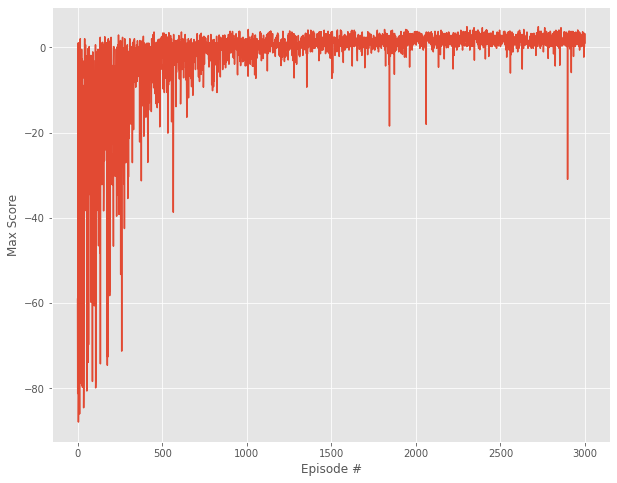

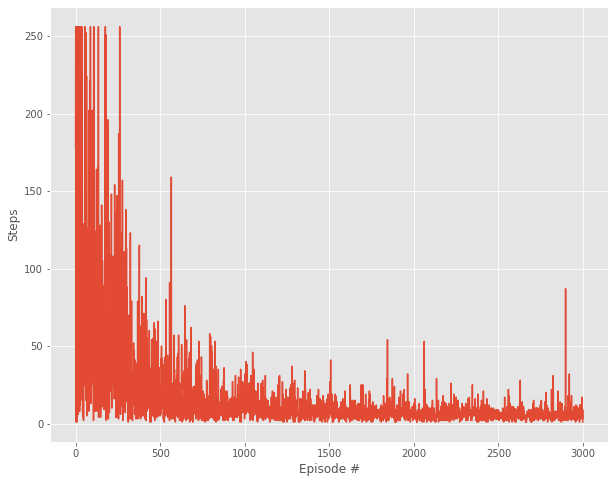

In [5]:
# reward_function = get_reward_function(config)
reward_function = get_reward_function({'training.reward': 'explicit_pos_reward'})

agent = get_agent(config)
env = gen_env(config['env'], reward_function)
scores, steps = run_episodes(env, agent, n_episodes=config['training.n_episodes'], verbose=config['training.verbose'])

display_stats(scores, steps)

### visualisation 

In [7]:
# env = gen_env(config['env'], reward_function, verbose=True)
# print(run_episode(env, agent, train_mode=False))

# show_video(config['env.video_path'])

In [5]:
import random
import torch
import numpy as np

from fast_tensor_data_loader import FastTensorDataLoader
from expected_steps import ExpectedStepsAmountModel
from rewards import ExpectedStepsAmount

In [6]:
grid_size = config['env.grid_size'] * config['env'].get('tile_size', 1)

In [7]:
expected_steps_learner = ExpectedStepsAmountModel(grid_size, config['training.reward_params'])
agent = get_agent(config)

2021-02-15 17:19:57,202 INFO    dqn                    : Running on device: cuda:0


In [9]:
env = gen_env(config['env'], reward_function=lambda *args: 0)
env.env.env.max_steps = 40  # TOBD: config
expected_steps_learner.model.fc[-1].bias.data.fill_(20.)

expected_steps_learner.reset_buffer()
expected_steps_learner.collect_episodes(env, agent)
expected_steps_learner.learn(verbose=True)

arr = np.array([x for _, _, x in expected_steps_learner.buffer])
logger.info(f'{np.quantile(arr, np.arange(0, 1, 0.1))}')    

2021-02-15 17:56:11,461 INFO    expected_steps         : Expected steps L1Loss:  8.341548559979023
2021-02-15 17:56:11,786 INFO    __main__               : [ 0.  3.  7. 11. 15. 19. 23. 27. 31. 36.]


In [11]:
# agent = get_agent(config)

In [18]:
expected_reward_function = ExpectedStepsAmount(expected_steps_learner.model)
env = gen_env(config['env'], reward_function=expected_reward_function)
# env.env.env.max_steps = 50  # TOBD: config

# agent.reset_buffer()
scores, steps = run_episodes(env, agent, n_episodes=3000, verbose=300)

2021-02-15 18:07:50,676 INFO    navigation_policy      : Episode: 100. Average score: 20.488332357406616. Average steps: 11.14
2021-02-15 18:08:01,170 INFO    navigation_policy      : Episode: 200. Average score: 20.45242280960083. Average steps: 11.24
2021-02-15 18:08:11,252 INFO    navigation_policy      : Episode: 300. Average score: 19.19407621383667. Average steps: 10.9
2021-02-15 18:08:20,673 INFO    navigation_policy      : Episode: 400. Average score: 19.858186540603636. Average steps: 10.07
2021-02-15 18:08:29,806 INFO    navigation_policy      : Episode: 500. Average score: 18.745119743347168. Average steps: 9.75
2021-02-15 18:08:38,646 INFO    navigation_policy      : Episode: 600. Average score: 19.506019258499144. Average steps: 9.48
2021-02-15 18:08:47,379 INFO    navigation_policy      : Episode: 700. Average score: 18.352522554397584. Average steps: 9.36
2021-02-15 18:08:53,511 INFO    navigation_policy      : Episode: 800. Average score: 19.191483087539673. Average ste

In [21]:
env = gen_env(config['env'], expected_reward_function, verbose=True)
print(run_episode(env, agent, train_mode=True))

show_video(config['env.video_path'])

2021-02-15 18:09:44,233 INFO    gym_minigrid_navigation.environments   : From [5 4] to [2 4]


(25.026907920837402, 7)


In [22]:
env = gen_env(config['env'], reward_function=lambda *args: 0)
env.env.env.max_steps = 40  # TOBD: config
expected_steps_learner.model.fc[-1].bias.data.fill_(20.)

expected_steps_learner.reset_buffer()
expected_steps_learner.collect_episodes(env, agent)
expected_steps_learner.learn(verbose=True)

arr = np.array([x for _, _, x in expected_steps_learner.buffer])
logger.info(f'{np.quantile(arr, np.arange(0, 1, 0.1))}')  

2021-02-15 18:41:26,907 INFO    expected_steps         : Expected steps L1Loss:  3.683513929332701
2021-02-15 18:41:26,999 INFO    __main__               : [ 0.  0.  1.  2.  3.  4.  5.  7. 10. 20.]


In [23]:
expected_reward_function = ExpectedStepsAmount(expected_steps_learner.model)
env = gen_env(config['env'], reward_function=expected_reward_function)
# env.env.env.max_steps = 50  # TOBD: config

agent.reset_buffer()
scores, steps = run_episodes(env, agent, n_episodes=3000, verbose=300)

2021-02-15 18:41:38,661 INFO    navigation_policy      : Episode: 300. Average score: 0.8298716926574707. Average steps: 10.35
2021-02-15 18:41:48,875 INFO    navigation_policy      : Episode: 600. Average score: 1.9542630004882813. Average steps: 9.453333333333333
2021-02-15 18:42:00,709 INFO    navigation_policy      : Episode: 900. Average score: 2.043362201054891. Average steps: 10.95
2021-02-15 18:42:10,735 INFO    navigation_policy      : Episode: 1200. Average score: 1.1871111615498862. Average steps: 9.23
2021-02-15 18:42:22,588 INFO    navigation_policy      : Episode: 1500. Average score: 1.398148104349772. Average steps: 10.943333333333333
2021-02-15 18:42:34,410 INFO    navigation_policy      : Episode: 1800. Average score: 1.5944499905904135. Average steps: 11.02
2021-02-15 18:42:49,365 INFO    navigation_policy      : Episode: 2100. Average score: 1.4068036874135335. Average steps: 13.26
2021-02-15 18:43:00,354 INFO    navigation_policy      : Episode: 2400. Average score

In [58]:
agent.eps

1

In [ ]:
stop

In [6]:
import torch

def metric(model, buffer, device=torch.device('cuda')):
    def _vstack(arr):
        arr = np.vstack([np.expand_dims(x, axis=0) for x in arr])
        return torch.from_numpy(arr).float()

    states, goal_states, y = map(_vstack, zip(*buffer))
    y = y.squeeze()
    y = torch.clamp(y, max=20)  # !!! hot fix
    model.eval()
    
    loss_fn = torch.nn.L1Loss()
    train_loader = FastTensorDataLoader(states, goal_states, y, batch_size=1000)

    loss_sum = 0
    for batch_state, batch_goal_state, batch_y in train_loader:
        with torch.no_grad():
            output = model(batch_state.to(device), batch_goal_state.to(device))
            loss = loss_fn(output, batch_y.to(device))
        loss_sum += loss.cpu().numpy().item()
    return loss_sum / len(train_loader)

In [7]:
import random
import torch
import numpy as np

from navigation_policy import *
from expected_steps import ExpectedStepsAmountLearner
from rewards import ExpectedStepsAmount
from fast_tensor_data_loader import FastTensorDataLoader

In [32]:
config = ConfigFactory.parse_file('../conf/minigrid_dqn_navigation_draft.hocon')
config['env']['video_path'] = '../outputs/video/'

grid_size = config['env.grid_size'] * config['env'].get('tile_size', 1)

In [33]:
expected_steps_learner = ExpectedStepsAmountLearner(grid_size, config['training.reward_params'])

env = gen_env(config['env'], reward_function=lambda *args: 0)
env.env.env.max_steps = 20  # TOBD: config
# expected_steps_learner.model.fc[-1].bias.data.fill_(10.)
    
expected_steps_learner.collect_episodes(env, agent)
valid_buffer = expected_steps_learner.buffer

print(len(valid_buffer))

3310


In [34]:
for i in range(20):
    expected_steps_learner.reset_buffer()
    expected_steps_learner.collect_episodes(env, agent)

    expected_steps_learner.learn()

    metric_valid = metric(expected_steps_learner.model, valid_buffer)
    metric_train = metric(expected_steps_learner.model, expected_steps_learner.buffer)
    mean_steps = sum([x for _, _, x in expected_steps_learner.buffer]) / len(expected_steps_learner.buffer)
    print(f"epochs {i}: metric_train = {metric_train :.2f}, metric_valid = {metric_valid :.2f}, mean_steps: {mean_steps}")

epochs 0: metric_train = 1.30, metric_valid = 1.01, mean_steps: 3.990359333917616
epochs 1: metric_train = 0.85, metric_valid = 0.75, mean_steps: 3.944684528954192
epochs 2: metric_train = 0.90, metric_valid = 0.91, mean_steps: 3.604601877081441
epochs 3: metric_train = 0.89, metric_valid = 0.75, mean_steps: 3.7652567975830817
epochs 4: metric_train = 0.74, metric_valid = 0.68, mean_steps: 3.7306195749775517
epochs 5: metric_train = 0.72, metric_valid = 0.70, mean_steps: 3.654358353510896
epochs 6: metric_train = 0.52, metric_valid = 0.52, mean_steps: 3.5375615763546797
epochs 7: metric_train = 0.63, metric_valid = 0.52, mean_steps: 3.69803328290469
epochs 8: metric_train = 0.84, metric_valid = 0.55, mean_steps: 3.860215053763441
epochs 9: metric_train = 0.51, metric_valid = 0.49, mean_steps: 3.6011473429951693
epochs 10: metric_train = 0.65, metric_valid = 0.48, mean_steps: 3.7357249626307922
epochs 11: metric_train = 0.66, metric_valid = 0.44, mean_steps: 3.8358959195742166
epochs 12

2021-02-15 14:36:45,035 INFO    dqn                    : Running on device: cuda:0
2021-02-15 14:38:37,268 INFO    navigation_policy      : Episode: 100. Average score: 4.936435294896365. Average steps: 103.4
2021-02-15 14:40:37,870 INFO    navigation_policy      : Episode: 200. Average score: 4.352691846489907. Average steps: 105.35
2021-02-15 14:42:32,605 INFO    navigation_policy      : Episode: 300. Average score: 4.646617170870304. Average steps: 98.52
2021-02-15 14:44:22,559 INFO    navigation_policy      : Episode: 400. Average score: 4.588771716393531. Average steps: 91.85
2021-02-15 14:45:54,390 INFO    navigation_policy      : Episode: 500. Average score: 4.336946324557066. Average steps: 75.63
2021-02-15 14:47:27,306 INFO    navigation_policy      : Episode: 600. Average score: 4.636464801728725. Average steps: 75.89
2021-02-15 14:48:49,780 INFO    navigation_policy      : Episode: 700. Average score: 4.363821742534637. Average steps: 63.63
2021-02-15 14:50:23,437 INFO    na

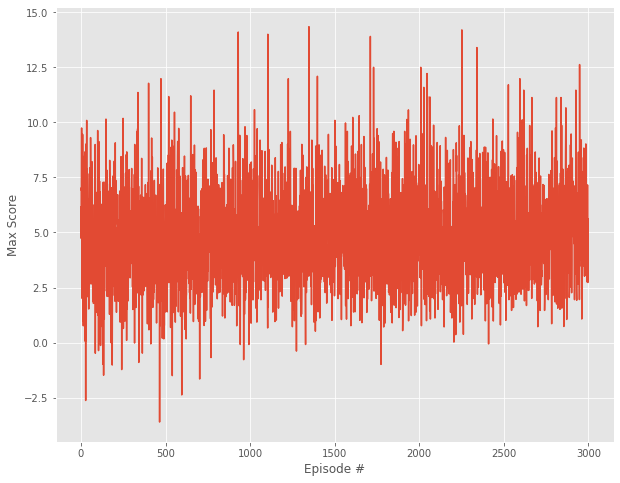

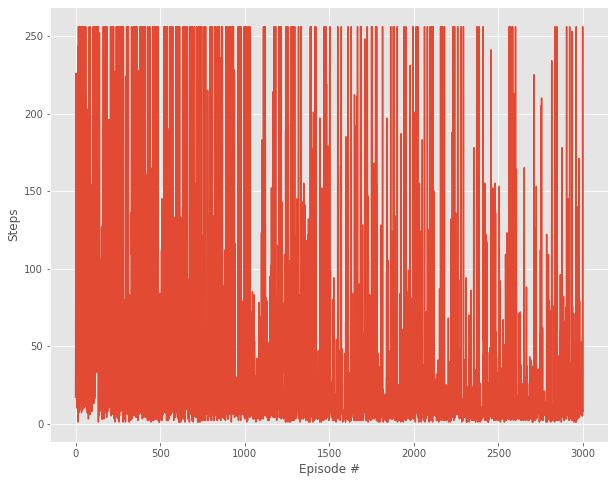

In [35]:
config['training']['n_episodes'] = 3000

expected_reward_function = ExpectedStepsAmount(expected_steps_learner.model)
env = gen_env(config['env'], reward_function=expected_reward_function)

new_agent = get_agent(config)
scores, steps = run_episodes(env, new_agent, n_episodes=config['training.n_episodes'], verbose=config['training.verbose'])

display_stats(scores, steps)

2021-02-15 14:04:43,318 INFO    dqn                    : Running on device: cuda:0
2021-02-15 14:06:06,199 INFO    navigation_policy      : Episode: 100. Average score: 3.772646605670452. Average steps: 106.52
2021-02-15 14:07:10,757 INFO    navigation_policy      : Episode: 200. Average score: 4.66359145000577. Average steps: 78.18
2021-02-15 14:08:21,033 INFO    navigation_policy      : Episode: 300. Average score: 4.818497596085072. Average steps: 82.7
2021-02-15 14:09:39,568 INFO    navigation_policy      : Episode: 400. Average score: 4.516974158585072. Average steps: 91.89
2021-02-15 14:10:56,782 INFO    navigation_policy      : Episode: 500. Average score: 4.95762783229351. Average steps: 88.83
2021-02-15 14:11:52,881 INFO    navigation_policy      : Episode: 600. Average score: 4.286891798824072. Average steps: 64.21
2021-02-15 14:13:09,933 INFO    navigation_policy      : Episode: 700. Average score: 4.78295204102993. Average steps: 88.35
2021-02-15 14:14:03,172 INFO    naviga

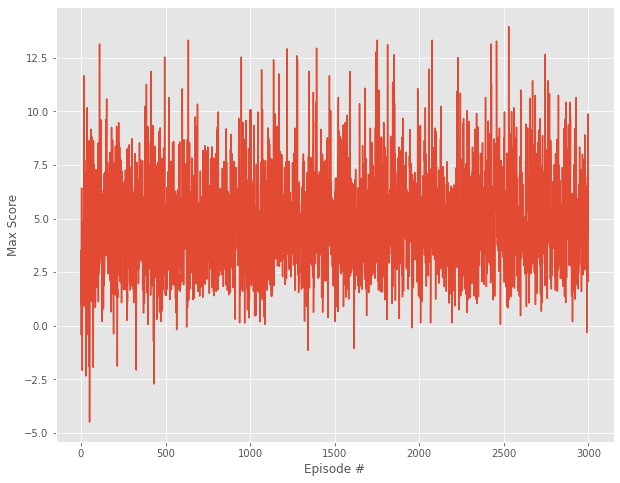

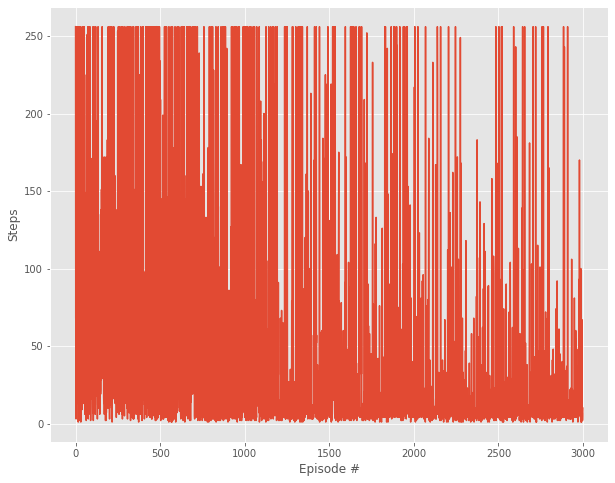

In [20]:
#

In [26]:
env = gen_env(config['env'], reward_function, verbose=True)
print(run_episode(env, new_agent, train_mode=False))

show_video(config['env.video_path'])

2021-02-15 14:27:07,830 INFO    gym_minigrid_navigation.environments   : From [5 2] to [3 4]


(-106.40158255585658, 256)


In [36]:
arr = np.array(steps[-300:])
logger.info(f'{np.quantile(arr, np.arange(0, 1, 0.1))}')

2021-02-15 15:09:48,388 INFO    navigation_policy      : [ 1.   2.   4.   6.   7.   8.  11.  15.3 31.  74.1]


In [5]:
config['training.reward_params']['buffer_size'] = 5_000

In [11]:
expected_steps_learner = ExpectedStepsAmountLearner(grid_size, config['training.reward_params'])
agent = get_agent(config)

2021-02-14 12:06:46,169 INFO    dqn                    : Running on device: cuda:0


In [ ]:
env = gen_env(config['env'], reward_function=lambda *args: 0, verbose=False)
env.env.env.max_steps = 4  # TOBD: config
expected_steps_learner.model.fc[-1].bias.data.fill_(2.)

expected_steps_learner.reset_buffer()
expected_steps_learner.collect_episodes(env, agent)
expected_steps_learner.learn(verbose=True)

arr = np.array([x for _, _, x in expected_steps_learner.buffer])
logger.info(f'{np.quantile(arr, np.arange(0, 1, 0.1))}')

expected_reward_function = ExpectedStepsAmount(expected_steps_learner.model, 2.5)

In [13]:
env = gen_env(config['env'], reward_function=lambda *args: 0, verbose=True)
state = env.reset()
goal_state = env.env.env.goal_state

import numpy as np

start_pos = (5, 3)
ens_pos = (2, 3)
state_ = np.copy(state)

2021-02-14 12:08:40,728 INFO    gym_minigrid_navigation.environments   : From [5 2] to [3 4]


In [21]:
next_state = np.copy(state_)
state = np.copy(state_)
expected_reward_function(state, next_state, goal_state), to_coords(state), to_coords(next_state), to_coords(goal_state)

(0.0, (5, 2), (5, 2), (3, 4))

In [22]:
state = np.copy(next_state)
next_state[4, 2] = next_state[5, 2]
next_state[5, 2] = [1, 0, 0]

expected_reward_function(state, next_state, goal_state), to_coords(state), to_coords(next_state), to_coords(goal_state)

(-0.10878205299377441, (5, 2), (4, 2), (3, 4))

In [23]:
state = np.copy(next_state)
next_state[3, 2] = next_state[4, 2]
next_state[4, 2] = [1, 0, 0]

expected_reward_function(state, next_state, goal_state), to_coords(state), to_coords(next_state), to_coords(goal_state)

(0.0, (4, 2), (3, 2), (3, 4))

In [24]:
state = np.copy(next_state)
next_state[3, 3] = next_state[3, 2]
next_state[3, 2] = [1, 0, 0]

expected_reward_function(state, next_state, goal_state), to_coords(state), to_coords(next_state), to_coords(goal_state)

(0.0, (3, 2), (3, 3), (3, 4))

In [25]:
state = np.copy(next_state)
next_state[3, 4] = next_state[3, 3]
next_state[3, 3] = [1, 0, 0]

expected_reward_function(state, next_state, goal_state), to_coords(state), to_coords(next_state), to_coords(goal_state)

(1.9482516050338745, (3, 3), (3, 4), (3, 4))

In [27]:
expected_reward_function = ExpectedStepsAmount(expected_steps_learner.model, 2.5)
env = gen_env(config['env'], reward_function=expected_reward_function)
# env.env.env.max_steps = 50  # TOBD: config

agent = get_agent(config)
agent.reset_buffer()

for x in range(40):
    scores, steps = run_episodes(env, agent, n_episodes=25, verbose=25)
    arr = np.array(steps)
    logger.info(f'{np.quantile(arr, np.arange(0, 1, 0.1))}')

2021-02-14 12:22:23,976 INFO    dqn                    : Running on device: cuda:0
2021-02-14 12:22:49,940 INFO    navigation_policy      : Episode: 25. Average score: -3.7160219421386667. Average steps: 135.64
2021-02-14 12:22:49,942 INFO    navigation_policy      : [  5.   46.4  69.2  82.2  92.2 116.  131.4 189.2 256.  256. ]
2021-02-14 12:23:13,857 INFO    navigation_policy      : Episode: 25. Average score: -2.2924211597442627. Average steps: 122.2
2021-02-14 12:23:13,860 INFO    navigation_policy      : [  4.   13.4  38.6  46.8  67.   99.  150.4 175.  251.8 256. ]
2021-02-14 12:23:36,129 INFO    navigation_policy      : Episode: 25. Average score: -3.120472784996025. Average steps: 111.72
2021-02-14 12:23:36,130 INFO    navigation_policy      : [  1.    4.8  13.8  54.8  76.8  96.  124.2 157.6 198.4 256. ]
2021-02-14 12:24:02,737 INFO    navigation_policy      : Episode: 25. Average score: -2.8701644096374492. Average steps: 132.36
2021-02-14 12:24:02,740 INFO    navigation_policy 

2021-02-14 12:44:00,299 INFO    navigation_policy      : Episode: 25. Average score: -1.2634456262588492. Average steps: 177.68
2021-02-14 12:44:00,302 INFO    navigation_policy      : [  1.   49.   70.  117.2 138.2 256.  256.  256.  256.  256. ]
2021-02-14 12:44:38,346 INFO    navigation_policy      : Episode: 25. Average score: -3.0942701635360716. Average steps: 183.12
2021-02-14 12:44:38,348 INFO    navigation_policy      : [  3.   15.   47.  132.2 256.  256.  256.  256.  256.  256. ]
2021-02-14 12:45:18,074 INFO    navigation_policy      : Episode: 25. Average score: -2.9446628742218026. Average steps: 192.12
2021-02-14 12:45:18,076 INFO    navigation_policy      : [  3.   30.4  74.  190.8 256.  256.  256.  256.  256.  256. ]
2021-02-14 12:45:53,152 INFO    navigation_policy      : Episode: 25. Average score: -4.279972639083862. Average steps: 169.56
2021-02-14 12:45:53,154 INFO    navigation_policy      : [  2.   13.4  21.  132.6 170.8 256.  256.  256.  256.  256. ]
2021-02-14 12

In [18]:
def to_coords(state):
    obj_pos = (state == 10).nonzero()
    return obj_pos[0].item(), obj_pos[1].item()

In [107]:
model = expected_reward_function.model
dist = model(expected_reward_function._to_torch(state), expected_reward_function._to_torch(goal_state))

to_coords(state), to_coords(goal_state), dist

((3, 3), (2, 3), tensor(3.2507, device='cuda:0', grad_fn=<SqueezeBackward0>))

In [70]:
expected_reward_function = ExpectedStepsAmount(expected_steps_learner.model)

In [68]:
state[:,:,0], next_state[:,:,0]

(array([[ 2,  2,  2,  2,  2,  2,  2,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1, 10,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  8,  2],
        [ 2,  2,  2,  2,  2,  2,  2,  2]], dtype=uint8),
 array([[ 2,  2,  2,  2,  2,  2,  2,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1, 10,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  8,  2],
        [ 2,  2,  2,  2,  2,  2,  2,  2]], dtype=uint8))

In [ ]:
state.shape

In [ ]:
next_state = np.copy(state)

next_state[1, 3] = 0
next_state[5, 3] = np.array([10, 0, 0])
expected_reward_function(state, next_state, goal_state)

In [ ]:
next_state = np.copy(state)
expected_reward_function(state, next_state, goal_state)

In [ ]:
goal_state[12:16, 12:16, 0]

In [ ]:
[:, :, 0]

In [ ]:
agent.qnetwork_target.master

In [ ]:
model = agent.qnetwork_target.master
model.output_size

In [ ]:
model(states).shape

In [ ]:
np.linalg.norm(state - goal_state) / 255

In [ ]:
state / np.linalg.norm(state)

In [ ]:
np.linalg.norm(state)

In [ ]:
state / 